Code adapted from:
Juho Laitala, Mingzhe Jiang, Elise Syrjälä, Emad Kasaeyan Naeini, Antti
Airola, Amir M. Rahmani, Nikil D. Dutt, and Pasi Liljeberg. 2020. Robust
ECG R-peak Detection Using LSTM. In The 35th ACM/SIGAPP Symposium
on Applied Computing (SAC ’20), March 30-April 3, 2020, Brno, Czech Republic
ACM, New York, NY, USA, Article 4, 8 pages. https://doi.org/10.1145/3341105.
3373945

In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

# Importing needed libraries
from matplotlib import pyplot as plt
from RNN_files import Laitala_data_original_file
import wfdb
from wfdb.io import get_record_list
from wfdb import rdsamp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.signal import resample_poly
import xarray as xr
import matplotlib.pyplot as plt
from RNN_files import Laitala_data_original_file
import tensorflow
from tensorflow.keras import layers, models, Input
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

Run this cell and not the one after if using simulated diffraction data.

In [2]:

# path = '/nsls2/users/shasko/Repos/internship_2025/datasets/ds_combined_500_patterns_NaCl.nc'
# ds = xr.open_dataset(path, engine="netcdf4")
# gaussians = ds["Intensities"]
# binary = ds["binary_arr"]
# x = ds["tth"].values

# window_size = 11763

Run this cell and not the previous one if using simulated Gaussian signals. 

In [3]:
path = '/nsls2/users/shasko/Repos/internship_2025/datasets/math_functions_smalldataset.nc' 
ds = xr.open_dataset(path, engine="netcdf4")

gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values
print(type(binary))

x = ds["x"].values
window_size = 1000

<class 'numpy.ndarray'>


In [4]:
ds

<xarray.Dataset>
Dimensions:    (pattern: 5000, x: 1000)
Coordinates:
  * pattern    (pattern) int64 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
  * x          (x) float64 0.0 0.01001 0.02002 0.03003 ... 9.97 9.98 9.99 10.0
Data variables:
    Gaussians  (pattern, x) float64 2.174e-17 3.766e-17 ... 2.613e-48 9.194e-49
    BinaryArr  (pattern, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [5]:

tv_gaussians, test_gaussians, tv_binary, test_binary = train_test_split(gaussians, binary, test_size=0.2, shuffle=False)

In [6]:
train_gaussians, val_gaussians, train_binary, val_binary = train_test_split(tv_gaussians, tv_binary, test_size=0.25, shuffle=False)

In [8]:
import wfdb
from wfdb.processing import (
    resample_singlechan,
    find_local_peaks,
    correct_peaks,
    normalize_bound
)

In [13]:
n_batch, n_timesteps, n_input_dim = 64, window_size, 1

model = models.Sequential()
model.add(Input(shape=(n_timesteps, n_input_dim)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


In [14]:
model.summary() # view model architecture

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1000, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, 1000, 1)           65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [15]:
checkpoint_path = 'training/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create callback to save model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=2) 

es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=3,
                                              min_delta=1e-5,
                                              verbose=2)

In [16]:
train_gaussians_reshaped = train_gaussians.reshape(train_gaussians.shape[0], train_gaussians.shape[1], 1)
val_gaussians_reshaped = val_gaussians.reshape(val_gaussians.shape[0], val_gaussians.shape[1], 1)
test_gaussians_reshaped = test_gaussians.reshape(test_gaussians.shape[0], test_gaussians.shape[1], 1)

In [17]:
train_binary_reshaped = train_binary.reshape(train_binary.shape[0], train_binary.shape[1], 1)
val_binary_reshaped = val_binary.reshape(val_binary.shape[0], val_binary.shape[1], 1)
test_binary_reshaped = test_binary.reshape(test_binary.shape[0], test_binary.shape[1], 1)

In [18]:
train_gaussians_sc = train_gaussians_reshaped

In [19]:
train_gaussians_reshaped.shape

(3000, 1000, 1)

In [20]:
train_binary_reshaped.shape

(3000, 1000, 1)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1000, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, 1000, 1)           65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(x=train_gaussians_reshaped,
          y=train_binary_reshaped,
          batch_size=64,
          epochs=40, 
          validation_data=(val_gaussians_reshaped, val_binary_reshaped),
          callbacks=[cp_callback, es_callback])

Epoch 1/40
47/47 [==============================] - 35s 660ms/step - loss: 0.2041 - acc: 0.9805 - val_loss: 0.0414 - val_acc: 0.9930

Epoch 00001: saving model to training/cp.ckpt
Epoch 2/40
47/47 [==============================] - 30s 635ms/step - loss: 0.0386 - acc: 0.9930 - val_loss: 0.0349 - val_acc: 0.9930

Epoch 00002: saving model to training/cp.ckpt
Epoch 3/40
47/47 [==============================] - 30s 631ms/step - loss: 0.0321 - acc: 0.9930 - val_loss: 0.0296 - val_acc: 0.9930

Epoch 00003: saving model to training/cp.ckpt
Epoch 4/40
47/47 [==============================] - 30s 630ms/step - loss: 0.0274 - acc: 0.9930 - val_loss: 0.0265 - val_acc: 0.9930

Epoch 00004: saving model to training/cp.ckpt
Epoch 5/40
47/47 [==============================] - 30s 633ms/step - loss: 0.0239 - acc: 0.9930 - val_loss: 0.0222 - val_acc: 0.9930

Epoch 00005: saving model to training/cp.ckpt
Epoch 6/40
47/47 [==============================] - 30s 639ms/step - loss: 0.0214 - acc: 0.9930 - va

In [23]:
binary_pred = model.predict(test_gaussians_reshaped,
                            verbose=2)

32/32 - 4s


In [24]:
binary_pred.shape

(1000, 1000, 1)

In [25]:
plt.close('all')

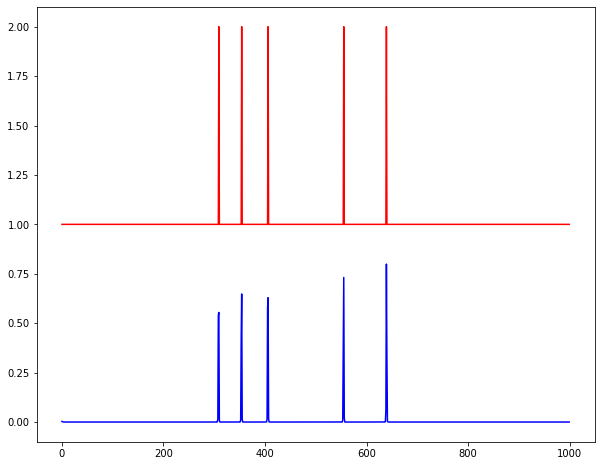

In [43]:
plt.figure(figsize=(10,8))
idx=16
plt.plot(binary_pred[idx], color='blue', label='Pred')
plt.plot(test_binary_reshaped[idx] + 1, color='red', label='True')
plt.show()

Evaluate accuracy: use f1 score, set prob >= 30% as positive, else negative


In [93]:
from sklearn.metrics import f1_score

In [ ]:
threshold = 0.3
binary_pred_adjusted_sklearn = (binary_pred >= threshold).astype(int)


In [122]:
test_binary_reshaped = test_binary_reshaped.astype(int)

In [123]:
f1 = f1_score(test_binary_reshaped.squeeze(), binary_pred_adjusted_sklearn.squeeze(), average='micro')

In [124]:
print(f1)

0.04422673198040588


Try evaluating on non-Guassian data now...

In [128]:
path = '/nsls2/users/shasko/Repos/internship_2025/saved_data/lorentzian_functions_smalldataset.nc' 
ds = xr.open_dataset(path, engine="netcdf4")

intensities_lor = ds["Intensities"].values
binary = ds["BinaryArr"].values
print(type(binary))

x = ds["x"].values
window_size = 1000

<class 'numpy.ndarray'>


In [129]:
from sklearn.preprocessing import MinMaxScaler

scaler_lor = MinMaxScaler()
intensities_lor_sc = scaler_lor.fit_transform(intensities_lor)

In [132]:
intensities_lor_sc_reshaped = intensities_lor_sc.reshape(intensities_lor_sc.shape[0],
                                                         intensities_lor_sc.shape[1],
                                                         1)

In [136]:
binary_lor_reshaped = binary.reshape(binary.shape[0],
                                 binary.shape[1],
                                 1)

In [133]:
pred_lor = model.predict(intensities_lor_sc_reshaped,
                         verbose=2)

157/157 - 15s


In [134]:
plt.close('all')

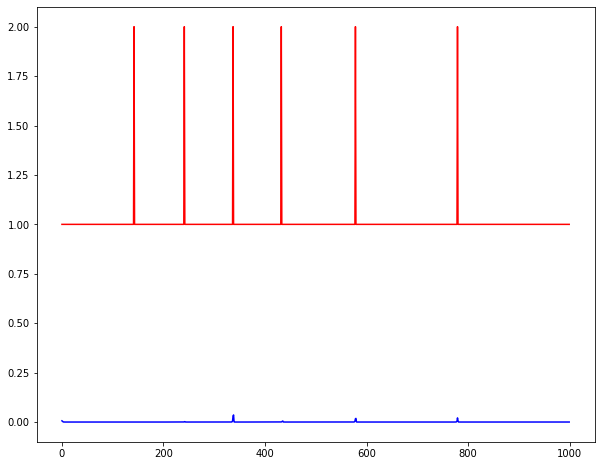

In [141]:
plt.figure(figsize=(10,8))
idx=4
plt.plot(pred_lor[idx], color='blue', label='Pred')
plt.plot(binary_lor_reshaped[idx] + 1, color='red', label='True')
plt.show()

Try evaluating on diffraction data now...

In [147]:
path = '/nsls2/users/shasko/Repos/internship_2025/datasets/ds_combined_500_patterns_NaCl.nc'
ds = xr.open_dataset(path, engine="netcdf4")
intensities_diff = ds["Intensities"].values
binary_diff = ds["binary_arr"].values
x = ds["tth"].values

window_size = 11763

In [148]:
scaler_diff = MinMaxScaler()
intensities_diff_sc = scaler_diff.fit_transform(intensities_diff)

In [149]:
intensities_diff_sc_reshaped = intensities_diff_sc.reshape(intensities_diff_sc.shape[0],
                                                           intensities_diff_sc.shape[1],
                                                           1)

In [150]:
binary_diff_reshaped = binary_diff.reshape(binary_diff.shape[0],
                                           binary_diff.shape[1],
                                           1)

In [151]:
pred_diff = model.predict(intensities_diff_sc_reshaped,
                         verbose=2)

16/16 - 20s


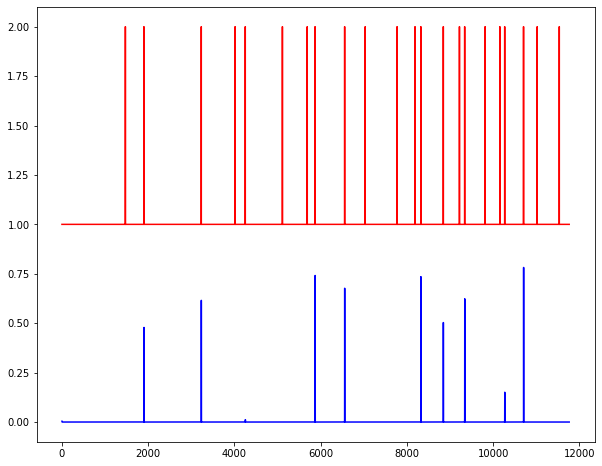

In [159]:
plt.figure(figsize=(10,8))
idx=200
plt.plot(pred_diff[idx], color='blue', label='Pred')
plt.plot(binary_diff_reshaped[idx] + 1, color='red', label='True')
plt.show()